# Visualizing SVMs with Pima Indians Diabetes Dataset

Welcome to the practical section of module 5.3. Here we'll work with one of the most powerful tools in machine learning: Support Vector Machines (SVMs). We'll be learning how to train a support vector machine classifier (or SVC) using scikit-learn on the [Pima Indians Diabetes Dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes), we'll also going to visulaize the SVMs by plotting the decision boundaries and the maximum margin with different kernels to acheive the best understanding of the practicals of SVMs.

In [89]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = (10, 10)

# Understanding and Visualizing the Data

The dataset we'll be working with here is one of the classics in the machine learning community. The dataset is a collection of clinical measurments for 768 women of the Pima Indian heritage and their diagnosis of diabetes. We have 8 clinical measurments like: Pregnancy Count, Blood Glucose, Body Mass Index (BMI), Diastolic Blood Pressure, ... etc. The diagnosis of diabetes is represented through the **Class** column: 1 means that the subject has diabetes, 0 means that the subject hasn't.

We can take a look at a sample of the data to understand better:

In [90]:
dataset = pd.read_csv('../datasets/pima-indians-diabetes.csv')
dataset.sample(10)

,Pregnancy Count,Blood Glucose,Diastolic BP,Triceps Skin Fold Thickness,Serum Insulin,BMI,Diabetes Pedigree Function,Age,Class
722,1,149,68,29,127,29.3,0.349,42,1
475,0,137,84,27,0,27.3,0.231,59,0
77,5,95,72,33,0,37.7,0.370,27,0
555,7,124,70,33,215,25.5,0.161,37,0
362,5,103,108,37,0,39.2,0.305,65,0
344,8,95,72,0,0,36.8,0.485,57,0
286,5,155,84,44,545,38.7,0.619,34,0
633,1,128,82,17,183,27.5,0.115,22,0
606,1,181,78,42,293,40.0,1.258,22,1
442,4,117,64,27,120,33.2,0.230,24,0


To simplify our work and make the visualizations feasable, we'll be focusing on only two features of the eight: **Blood Glucose** and **Body Mass Index (BMI)**. We'll now extract our focus dataset and see a summary of the values for both features:

In [93]:
focus_dataset = dataset[["Blood Glucose", "BMI", "Class"]]
focus_dataset.is_copy = False

x1_min, x1_max = focus_dataset["Blood Glucose"].min(), focus_dataset["Blood Glucose"].max()
x1_avg = np.mean(focus_dataset["Blood Glucose"])

x2_min, x2_max = focus_dataset["BMI"].min(), focus_dataset["BMI"].max()
x2_avg = np.mean(focus_dataset["BMI"])

print "Blood Glucose: min = %d, max = %d, mean = %0.2f" % (x1_min, x1_max, x1_avg)
print "BMI: min = %0.1f, max = %0.1f, mean = %0.2f" % (x2_min, x2_max, x2_avg)

focus_dataset.sample(10)

Blood Glucose: min = 0, max = 199, mean = 120.89
BMI: min = 0.0, max = 67.1, mean = 31.99


,Blood Glucose,BMI,Class
704,110,28.4,0
236,181,35.9,1
633,128,27.5,0
83,101,24.6,0
684,136,0.0,0
682,95,44.6,0
349,0,41.0,1
486,139,40.7,0
231,134,46.2,1
115,146,31.2,1


From the data summary we can notice two things:
1. There are some instances where the **Blood Glucose** and **BMI** take the value of 0. This is biologically impossible! This is probably due to errors in recording the data, so we need to filter those instances out of the dataset.

2. The features span a wide range, this can cause computational problems when we try to plot and visualize the results we get from our models. A good idea would be to scale the features into a reasonbale range.

We'll start by cleaning the data from the 0-valued instances.

In [95]:
# filtering the data out of 0-valued instances
real_bg = focus_dataset["Blood Glucose"] != 0
real_bmi = focus_dataset["BMI"] != 0

focus_dataset = focus_dataset[real_bg & real_bmi]

x1_min, x1_max = focus_dataset["Blood Glucose"].min(), focus_dataset["Blood Glucose"].max()
x1_avg = np.mean(focus_dataset["Blood Glucose"])

x2_min, x2_max = focus_dataset["BMI"].min(), focus_dataset["BMI"].max()
x2_avg = np.mean(focus_dataset["BMI"])

print "Blood Glucose: min = %d, max = %d, mean = %0.2f" % (x1_min, x1_max, x1_avg)
print "BMI: min = %0.1f, max = %0.1f, mean = %0.2f" % (x2_min, x2_max, x2_avg)

focus_dataset.sample(10)

Blood Glucose: min = 44, max = 199, mean = 121.94
BMI: min = 18.2, max = 67.1, mean = 32.45


,Blood Glucose,BMI,Class
309,124,32.9,1
521,124,33.2,0
320,129,27.5,0
91,123,32.0,0
192,159,30.4,1
659,80,34.2,1
609,111,24.0,0
291,107,36.6,1
703,129,38.5,0
254,92,27.6,1


Now after we have cleaned tha data and have all our instances at biologically plausiable values, we turn to scaling the values of the features. We're gonna use the same technique we used back then when we were doing linear regression. We'll fit our scalar on the training data then use the fitted scalar to transform the rest of the data (the test data).

In [37]:
def scale_features(X, scalar=None):
    if(len(X.shape) == 1):
        X = X.reshape(-1, 1)
    
    if scalar == None:
        scalar = StandardScaler()
        scalar.fit(X)
  
    return scalar.transform(X), scalar

In [96]:
# scaling the features
size = len(focus_dataset)
training_size = np.floor(size * 0.7).astype(int)

training_portion = focus_dataset.loc[:training_size, ("Blood Glucose", "BMI")]
test_portion = focus_dataset.loc[training_size:, ("Blood Glucose", "BMI")]

focus_dataset.loc[:training_size, ("Blood Glucose", "BMI")], train_scalar = scale_features(training_portion)
focus_dataset.loc[training_size:, ("Blood Glucose", "BMI")],_ = scale_features(test_portion, scalar=train_scalar)

x1_min, x1_max = focus_dataset["Blood Glucose"].min(), focus_dataset["Blood Glucose"].max()
x2_min, x2_max = focus_dataset["BMI"].min(), focus_dataset["BMI"].max()

focus_dataset.sample(10)

,Blood Glucose,BMI,Class
64,-0.266973,0.062992,1
662,1.461708,0.735630,1
529,-0.364823,-1.086099,0
153,1.005075,1.156029,0
219,-0.332206,0.763656,1
709,-0.951922,0.791683,1
419,0.222276,-0.833859,1
633,0.189660,-0.679713,0
642,0.809376,-0.399447,1
370,1.657408,0.847736,1


Now, that we've finished preprocessing our data, we finally visualize the distribution of our data points by sactter plotting them. The green data points reprsent the healthy subjects, and the red ones represent the diabetics. 

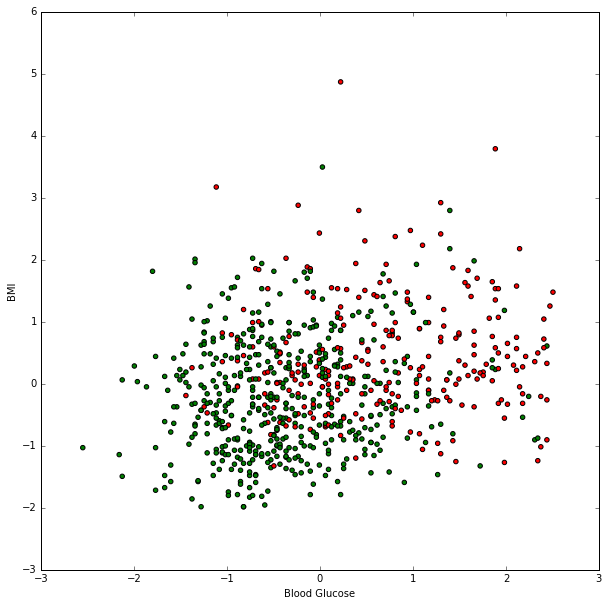

In [100]:
plt.figure()

colors = ['green' if diagnosis == 0 else 'red' for diagnosis in focus_dataset["Class"]]
plt.scatter(focus_dataset["Blood Glucose"], focus_dataset["BMI"], c=colors)

plt.xlabel("Blood Glucose")
plt.ylabel("BMI")

plt.show()

# Building SVM Models

Now we're ready to start building our SVMs. we're going to use **SVC** from scikit-learn's SVM package. The **SVC** implements the objective function we learned about in the videos:

$$\text{min} \hspace{0.5em} \frac{1}{2}||w||^2 + C\sum_{i=1}^{M}\zeta_{i} \hspace{0.5em} \text{subject to} \hspace{0.5em} y_ih_w(x_i) \geq 1 - \zeta_i$$

Our hypothesis function is in the usual form: $h_w(x) = w^T\phi(x) + b$, where $\phi$ is the mapping we use (if any) from our feature space to a higher dimensional feature space. This same hypothesis function can be written in an alternative form (called the dual form) that involves the kernel function we discussed in the video:

$$h_w(x) = \rho + \sum_{i=1}^{M}y_i\alpha_iK(x,x_i)$$

The details of how the two formulas are equivelant are mathematically complex, but you can say that $\rho$ relates to $b$ and $\alpha_i$ relates the weights $w$. The kernel function $K$ allows us to do our comuptations in the higher dimensional feature space without explicitly using $\phi$ which saves us a lot of computations. This is why the dual form is useful.

Practicaly, we can use **SVC** in the same way we used **LogisticRegression** and **SGDRegressor**: we instantiate a model, fit to the training data, and score it on the test data. We'll be concerend with two arguments when we instantiate our model:

* ***kernel***: which is the kernel function we're going to use with our model.
* ***C***: which is the slack variables penality in the objective function above.

We'll start by splitting our data into a training and a testing part, then we proceed to try out different SVMs with different kernels.

In [101]:
X_train = focus_dataset[["Blood Glucose", "BMI"]][:training_size]
y_train = focus_dataset["Class"][:training_size]

X_test = focus_dataset[["Blood Glucose", "BMI"]][training_size:]
y_test = focus_dataset["Class"][training_size:]

## Linear Kernel

We'll start with the simplest kernel there is: the linear kernel. This kernel takes the doct product form:
$$K(x_i,x_i') = x_i.x_i'$$
With this kernel, we just stay in our feature space, no mapping to a higher dimensional space is done. We can chose to train our model with the linear kernel by passing *kernel='linear'* as an argument when we construct the model.

In [133]:
model = SVC(kernel='linear', C = 1.0)
model.fit(X_train, y_train)

mean_accuracy = model.score(X_test, y_test)

mean_accuracy_train = model.score(X_train, y_train)
mean_accuracy_test = model.score(X_test, y_test)

print "Mean Accuracy on Train Data: %0.3f" % (mean_accuracy_train)
print "Mean Accuracy on Test Data: %0.3f" % (mean_accuracy_test)

Mean Accuracy on Train Data: 0.760
Mean Accuracy on Test Data: 0.770


After we trained our model we can start visualizing it. You may notice that the visualization script is a little more complex than what we used to do before, that's because here we're trying to visualize so many things: the classes clouds (represented by the blue and brown sections), the optimal hyperplane (the solid line in the middle), the maximum margin (defined by the two dashed lines) and the support vectors of the model(the circled data points). The script may look scary, but it'll be much simpler when you go through it.

Notice that we're using a method called **decision_function**: this method returns the distance each data points from the seperating hyperplane. We use these values to create the colored cloud, the optimal hyperplane and the maximum margin lines. We're also using the model's **support\_vectors_** attribute to get the support vectors of each class.

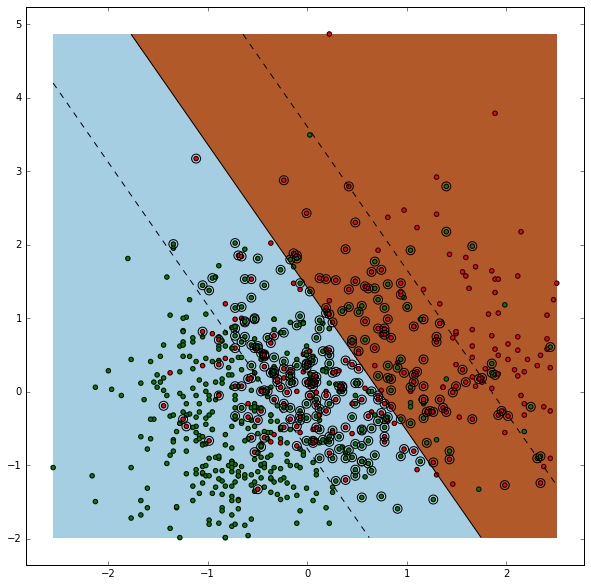

In [134]:
plt.figure()  # we just create a metaplotlib figure as usual

# we create the coordinate matrix for the colored meshes
# instead of using the features values directly like we did before
# we use ranges of between min and max of each feature with 0.01 step to make the boundaries smoother
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))

# we calculate the z values for the colored mesh
# we use .ravel() to faltten the matricies and np.c_ to concatnate them
z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# here we plot the colored meshes
# notice that we use the z > 0: this will create 2 colors, one for values of z > 0, the other for z <= 0
# if we used all z directly we'll get so many colors for each value that z can take
plt.pcolormesh(xx, yy, z > 0, cmap=cm.Paired)

# here we plot the lines of the optimal hypreplane the maximum margin
# these lines are the contours of the regions where z value are -1, 0, 1
plt.contour(xx, yy, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1., 0, 1.])

# this is our regular scatter plot of the data points
plt.scatter(focus_dataset["Blood Glucose"], focus_dataset["BMI"], c=colors)

# here we sacctter some big circles in the positions of the support vectors
# this will result in the support vectors datapoints being circled
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80,facecolors='none')

# we finally show the plot!
plt.show()

We can see in the plot:
* **The Optimal Hyperplane**: the solid line on the boundary of the two colors.
* **The Maximum Mrgin**: defined by the two dashed lines on the two regions.
* **The Support Vectors**: the circled data points.

You're encouraged to twaek the value of the parameter $C$ and see how the resulting model is affected. Try reducing the value of $C$, which means that you restrict the allowance for noisy data ponints to violate the margins, and notice how the model's accuracy is affected and the how the maximum margin gets wider as you go smaller on the value of $C$.

## RBF Kernel

The Radial Basis Function (or the RBF) kernel is one of the most facinating kernels we can work with. This kernel can produce a very non-linear solution that can adapt to the most noisy datasets. It's computed using:

$$K(x_i,x_i') = exp(-\gamma.||x_i - x_i'||^2)$$

An interesting fact about this kernel is that it opeartes in an **infinte** dimensions feature space! Yes, this formula is the dot product of two vectors in an infinite dimensional feature space! This is why the idea of kernel tricks and the use of the dual form is so facinating. Without those, we'd have been forced to calculate the mapping $\phi:R^2 \rightarrow R^\infty$ for each data point and store it in the memory to be reused, and this is practicaly impossible!

To use that kernel, we pass *kernel='rbf'* to the constructor of our model. We can also change the value of the **free parameter** $\gamma$ through the argument *gamma*.

In [149]:
model = SVC(kernel='rbf', gamma = 1.0, C = 1.0)
model.fit(X_train, y_train)

mean_accuracy_train = model.score(X_train, y_train)
mean_accuracy_test = model.score(X_test, y_test)

print "Mean Accuracy on Train Data: %0.3f" % (mean_accuracy_train)
print "Mean Accuracy on Test Data: %0.3f" % (mean_accuracy_test)

Mean Accuracy on Train Data: 0.764
Mean Accuracy on Test Data: 0.765


Notice how the model works slightly better on the training data but slightly worse on the test data, this is beacuse of the non-linearity of the decision boundary that fit with the training data as much as possible. We can visualize that nonlinear solution using the same script we used for the linar kernel, no changes whatsoever!

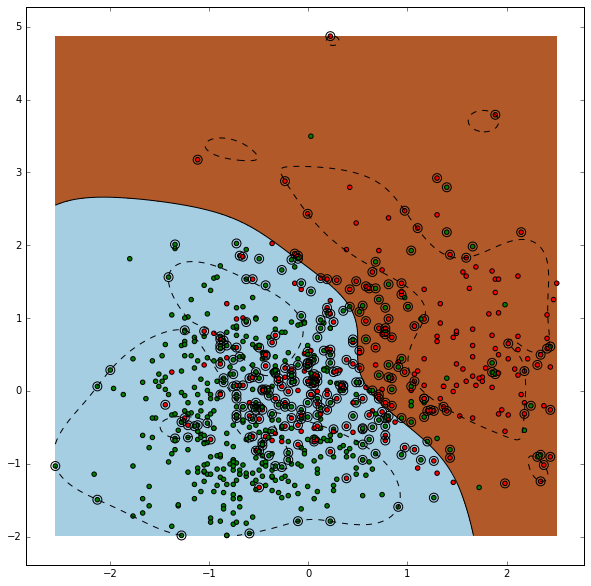

In [150]:
plt.figure()

xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.pcolormesh(xx, yy, z > 0, cmap=cm.Paired)
plt.contour(xx, yy, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1., 0, 1.])
plt.scatter(focus_dataset["Blood Glucose"], focus_dataset["BMI"], c=colors)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80,facecolors='none')

We can produce even more non-linear solution by increasing the value of $\gamma$, let's put it to 10 and see what happens.

In [151]:
model = SVC(kernel='rbf', gamma = 10.0, C = 1.0)
model.fit(X_train, y_train)

mean_accuracy_train = model.score(X_train, y_train)
mean_accuracy_test = model.score(X_test, y_test)

print "Mean Accuracy on Train Data: %0.3f" % (mean_accuracy_train)
print "Mean Accuracy on Test Data: %0.3f" % (mean_accuracy_test)

Mean Accuracy on Train Data: 0.816
Mean Accuracy on Test Data: 0.757


Notice that the model got much better with the training data but got slightly worse with test ones. This is the classic **bias/variance tradeoff** we encounter everywhere in machine learning. In our case here, the model is very nonlinear and very complex that it fits so well to the noise of the training data but can't generalize as well to new unseen data. We can take a look at the complexity of the nonlinear solutions we have via the following plot that shows how data points are grouped into islands!

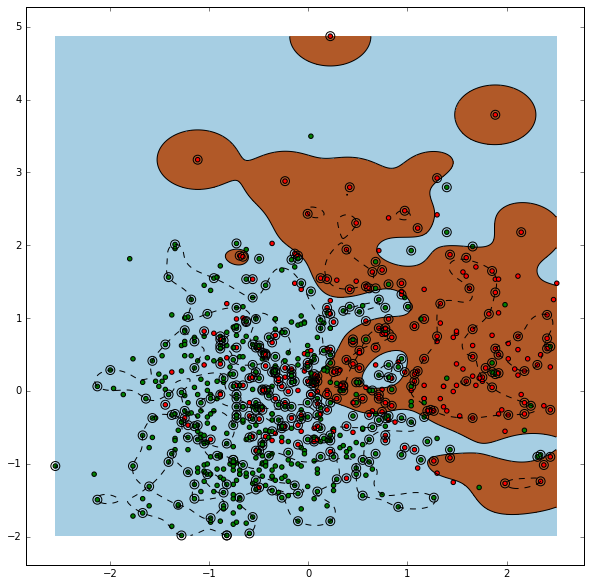

In [152]:
plt.figure()

xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.pcolormesh(xx, yy, z > 0, cmap=cm.Paired)
plt.contour(xx, yy, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1., 0, 1.])
plt.scatter(focus_dataset["Blood Glucose"], focus_dataset["BMI"], c=colors)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80,facecolors='none')

## Polynomial Kernels

Another kind of kernels we can work with is the polynomial kernel. This kernel impliciltly maps our feature space to a $d$ dimensional feature space through the equation:

$$K(x_i,x_i') = (\gamma.(x_i.x_i') + r)^d$$

Where $d$ is the dgeree of the polynomial and $\gamma,r$ are **free parameters**. To train a model using this kernel we pass *kernel='poly'*. We can change the values of $d,\gamma,r$ using the arguments *degree, gamma, and coef0* respectively.

In [159]:
model = SVC(kernel='poly', degree=3)
model.fit(X_train, y_train)

mean_accuracy_train = model.score(X_train, y_train)
mean_accuracy_test = model.score(X_test, y_test)

print "Mean Accuracy on Train Data: %0.3f" % (mean_accuracy_train)
print "Mean Accuracy on Test Data: %0.3f" % (mean_accuracy_test)

Mean Accuracy on Train Data: 0.726
Mean Accuracy on Test Data: 0.761


We notice that the polynomial kernel of the 3rd degree does a better job on the test data than our initial RBF kernel, that's because the nonlinearity of the model is less complex than RBF's. This can be seen in the following visualization of the ploynomial kernel solution.

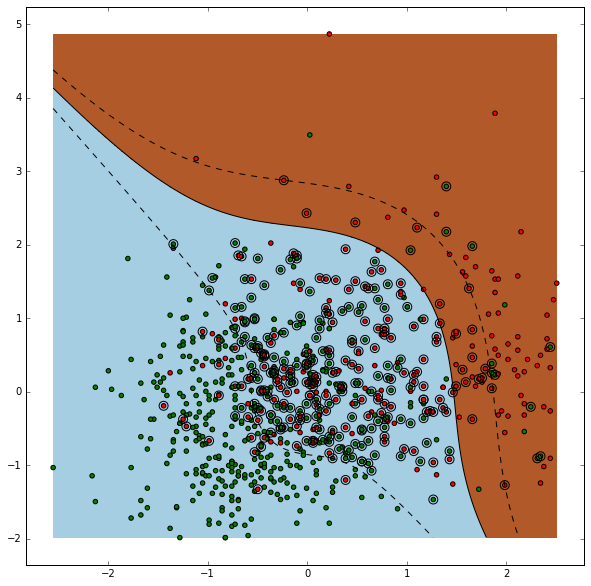

In [161]:
plt.figure()

xx, yy = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

plt.pcolormesh(xx, yy, z > 0, cmap=cm.Paired)
plt.contour(xx, yy, z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1., 0, 1.])
plt.scatter(focus_dataset["Blood Glucose"], focus_dataset["BMI"], c=colors)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80,facecolors='none')